借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！

In [1]:
from sklearnex import patch_sklearn
patch_sklearn() 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from typing import Tuple

import tensorflow as tf 
from keras.layers import MaxPooling1D, Dropout, Flatten, Dense, Input,Lambda,RepeatVector,Permute,Multiply,LSTM,Conv1D,Bidirectional,Activation,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow import keras

K =tf.keras.backend

import datetime
import os


# from attention_utils import get_activations
#   pip install pandas matplotlib scikit-learn-intelex scikit-learn openpyxl tensorboard seaborn
#更好地兼容 Python 3 的行为和特性，使得代码可以在 Python 2 和 Python 3 下运行得更加一致
# from __future__ import absolute_import,division,print_function,unicode_literals


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
print(f'{datetime.datetime.now()} tensorflow版本:',tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

2024-03-11 17:41:05.482534 tensorflow版本: 2.16.1
[]
Available GPU devices: []


In [3]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print("----- activations -----")
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [
            layer.output for layer in model.layers if layer.name == layer_name
        ]  # all layer outputs
    funcs = [
        K.function([inp] + [K.learning_phase()], [out]) for out in outputs
    ]  # evaluation functions
    layer_outputs = [func([inputs, 1.0])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print("shape为", layer_activations.shape)
            print(layer_activations)
    return activations
def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y
def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y
def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, :, attention_dim] = np.tile(y[:], (1, time_steps))
    return x, y

In [4]:
refeshdata=False
if refeshdata or 'dfstate' not in locals() or (hasattr(locals()['dfstate'], 'empty') and locals()['dfstate'].empty):
    dfstate = pd.read_csv("./data/states.txt")
    dfstate["start"] = dfstate.apply(
        lambda row: row["date"] + " " + row["start_time"], axis=1
    )
    dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
    dfstate["label"] = dfstate.pop("state").str.strip()
    # 转为时间类型
    dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
    # dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
    # dfstate['label'] = dfstate.apply(number_to_label,axis=1)
    dfstate.to_csv("./data/states.csv")
    print(dfstate.head(), dfstate.shape)


         date start_time  end_time               start                 end  \
0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   

  label  
0     装  
1     卸  
2     装  
3     卸  
4     装   (56, 6)


In [5]:
dfstate.head()

,date,start_time,end_time,start,end,label
0,2023-12-17,10:44:49,10:48:59,2023-12-17 10:44:49,2023-12-17 10:48:59,装
1,2023-12-17,11:29:45,11:31:55,2023-12-17 11:29:45,2023-12-17 11:31:55,卸
2,2023-12-17,12:23:56,12:29:44,2023-12-17 12:23:56,2023-12-17 12:29:44,装
3,2023-12-17,12:55:08,12:56:28,2023-12-17 12:55:08,2023-12-17 12:56:28,卸
4,2023-12-17,13:45:02,13:45:42,2023-12-17 13:45:02,2023-12-17 13:45:42,装


In [6]:
# 定义读取数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果
    inputDF.insert(0, "before", False)
    inputDF.insert(0, "after", False)
    inputDF.insert(0, "label", "-")
    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        
        
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]
        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass
        
    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF
def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
if refeshdata or 'odf17' not in locals() or (hasattr(locals()['odf17'], 'empty') and locals()['odf17'].empty):
    # 如果df未定义或为空DataFrame
    odf17 = read_data("./data/data_17.xlsx")
    odf21 = read_data("./data/data_21.xlsx")
    odf22 = read_data("./data/data_22.xlsx")
    odf23 = read_data("./data/data_23.xlsx")



In [7]:

numeric_col_names = ["原始重量", "稳定重量", "轴重","wpu_z",  "su_z", "速度" ]
# delete some
#  "轨迹时间",'原始重量_diff', '稳定重量_diff', '轴重_diff','su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff','估计重量',    'su_x_diff','su_y_diff', 'su_z_diff',  ,
# ['原始重量', '稳定重量', '轴重', 'su_ad',
#                 'wpu_x', 'wpu_y', 'wpu_z',
#                 'su_x', 'su_y', 'su_z',
#                 '原始重量_diff', '稳定重量_diff', '轴重_diff',
#                 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
#                 'su_x_diff', 'su_y_diff', 'su_z_diff',
#                 '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶']
label_col_names = ["label"]
time_col_names = ["时间"]

all_col_names=numeric_col_names + label_col_names + time_col_names
df17, df21, df22 ,df23 =odf17[all_col_names], odf21[all_col_names], odf22[all_col_names], odf23[all_col_names]
_origindata = pd.concat([df17, df21,df22], axis=0, ignore_index=True)

print(_origindata.columns)
print(_origindata.shape)
display(df17.shape,df22.shape,df23.shape,df23.shape)

_origindata.head()

Index(['原始重量', '稳定重量', '轴重', 'wpu_z', 'su_z', '速度', 'label', '时间'], dtype='object')
(69407, 8)


(16530, 8)

(27913, 8)

(27942, 8)

(27942, 8)

,原始重量,稳定重量,轴重,wpu_z,su_z,速度,label,时间
0,-4063,2020,-4375,76328,87720,0.0,-,2023-12-17 09:39:23
1,-4175,2020,-4364,76355,87720,0.0,-,2023-12-17 09:39:26
2,-4575,2020,-4486,76342,87725,0.0,-,2023-12-17 09:39:30
3,-4330,2020,-4397,76342,87731,0.0,-,2023-12-17 09:39:32
4,-4442,2020,-4475,76343,87720,0.0,-,2023-12-17 09:39:35


In [8]:
# 假设你有一个Pandas DataFrame
# df = pd.DataFrame({
#     'feature1': [...],  # 假设是一列数值列表
#     'feature2': [...],  # 另一列数值列表
#     'label': [...]      # 假设是一列标签
# })

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def dataframe_to_tfrecord(df, filename):
    writer = tf.io.TFRecordWriter(filename)

    for _, row in df.iterrows():
        feature = {
            'feature1': _float_feature(row['feature1']),
            'feature2': _float_feature(row['feature2']),
            'label': _float_feature(row['label'])
            # 更改此部分以适应你的数据类型和列名
        }

        example = tf.train.Example(features=tf.train.Features(feature=feature))
        serialized_example = example.SerializeToString()

        writer.write(serialized_example)

    writer.close()

# 调用函数将DataFrame写入TFRecords文件
# dataframe_to_tfrecord(df, 'my_data.tfrecords') 



In [9]:
def expandRows(idx_list_list, windowsize=20)->np.ndarray:
    my_array = np.arange(-windowsize, windowsize+1)
    new_array=idx_list_list.copy()
    for item in my_array:
        new_array += [element + item for element in indices_list]
    ret =np.sort(list(dict.fromkeys(new_array)))

    return ret

indices_list =_origindata.index[_origindata['label'] == '装'].tolist() + _origindata.index[_origindata['label'] == '卸'].tolist()
indices_list=expandRows(indices_list)

# 或者使用.iloc基于位置索引（如果是整数索引）
df_selected = _origindata.iloc[indices_list]

df_selected.head()

,原始重量,稳定重量,轴重,wpu_z,su_z,速度,label,时间
1231,-9307,0,-9786,76550,85407,0.0,-,2023-12-17 10:43:45
1232,-10766,0,-10654,76551,85561,0.0,-,2023-12-17 10:43:47
1233,-10654,0,-10677,76583,85605,0.0,-,2023-12-17 10:43:51
1234,-10632,0,-9753,76678,85753,0.0,-,2023-12-17 10:43:54
1235,-16595,0,-17179,76090,85995,0.0,-,2023-12-17 10:43:57


c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages

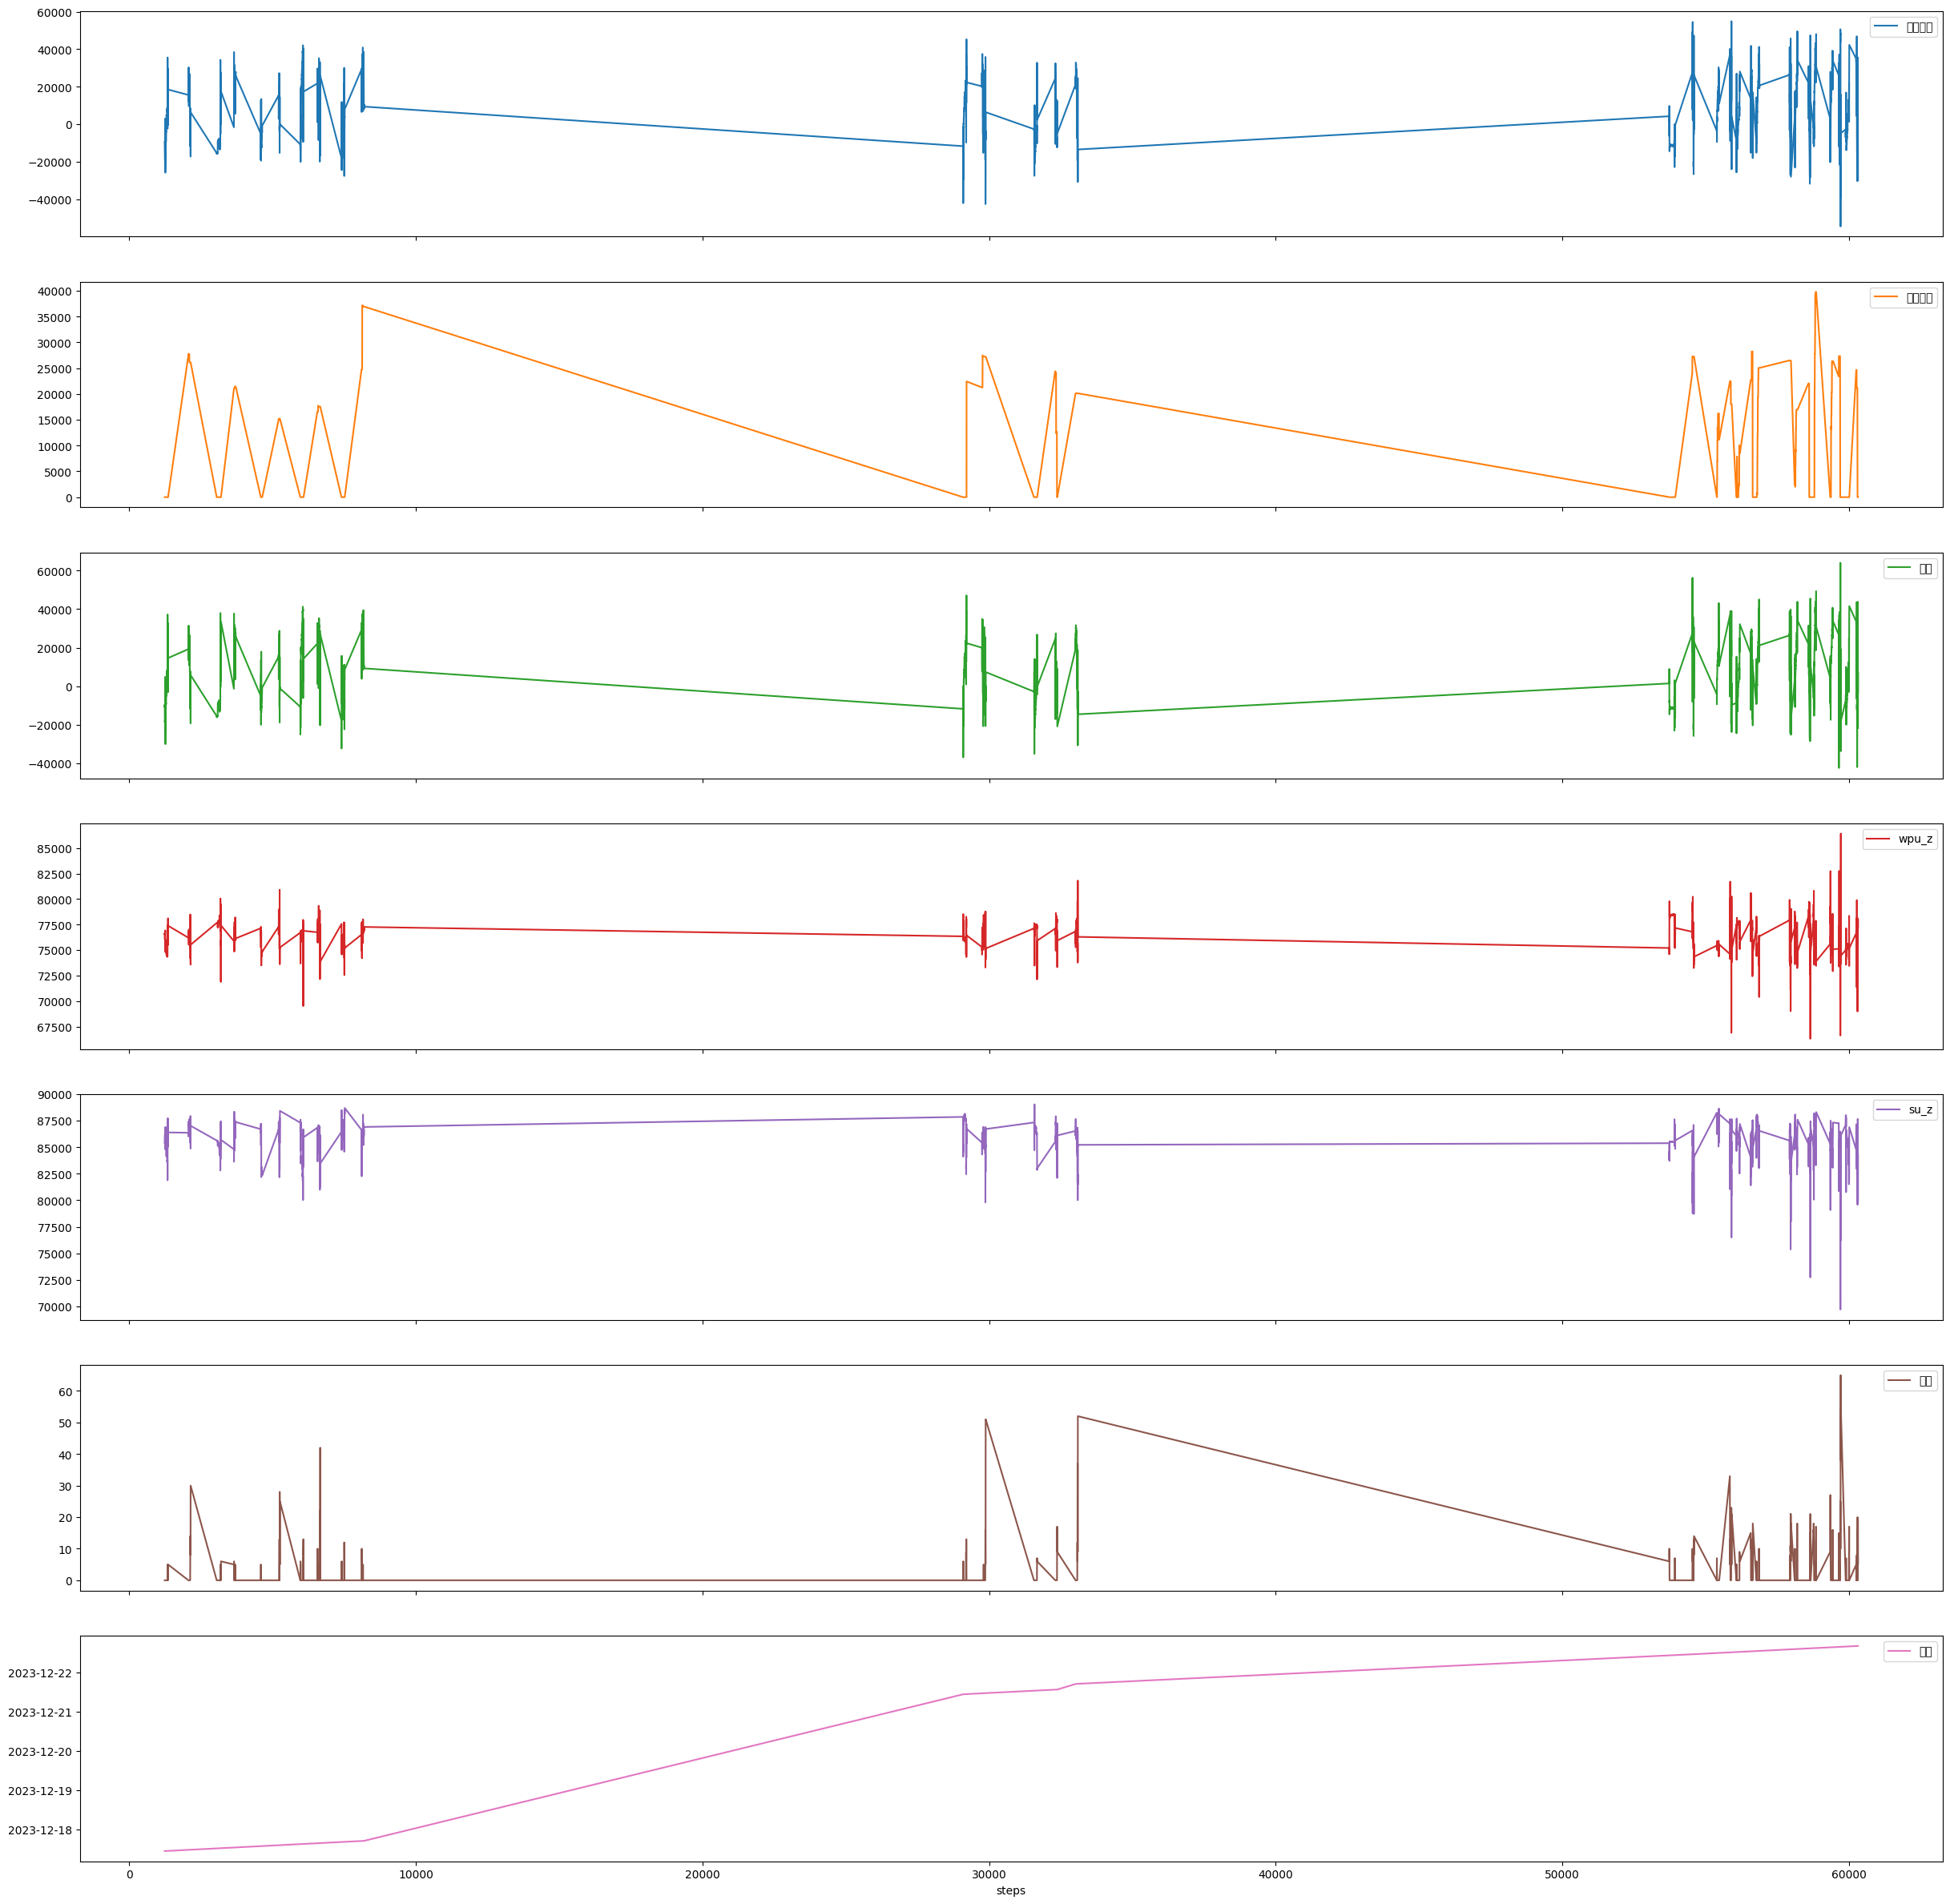

In [10]:
df_selected.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
ax = plt.gca()
# ax.set_xlim(left=0, right=7600)
# 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['DejaVu Sans']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['DejaVu Sans']
plt.show()



### 改各自层数！

In [11]:
# from sklearn.preprocessing import OneHotEncoder


# def normalize(
#     inpudf: pd.DataFrame,
#     numeric_col_names: list[str],
#     label_col_names: list[str],
#     time_col_names: list[str],
# ) -> Tuple[pd.DataFrame, MinMaxScaler, OneHotEncoder]:
#     inpudf = inpudf.copy()
#     # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
#     # 创建标准化器对象

#     inpudf[numeric_col_names] =inpudf[numeric_col_names].apply(pd.to_numeric)
#     scaler = MinMaxScaler(feature_range=(-10, 10))
#     scaler.fit(inpudf[numeric_col_names])
#     # （label）标准化
#     le = OneHotEncoder()
#     # ["装", "卸",'-']
#     le.fit(inpudf[label_col_names])
#     # newdata=np.array(inpudf)
#     # 数值型数据标准化： 使用StandardScaler或者MinMaxScaler进行标准化处理。
#     for col in numeric_col_names:
#         inpudf[col] = le.fit_transform(inpudf[col])
    
#     # 将所有时间列转换为Unix时间戳（单位为秒）
#     for col in time_col_names:
#         inpudf[col] = (
#             inpudf[col].astype(np.int64) / 1e9
#         )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）
        
#     # 类别数据（label）标准化： 类别数据通常不做标准化，而是进行编码，比如One-Hot编码或者Label Encoding。
#     for col in label_col_names:
#         inpudf[col] = le.fit_transform(inpudf[col])
#     # 时间数据标准化： 时间数据通常不进行标准化，而是转换成可以比较的形式，如Unix时间戳或时间段差。
#     return inpudf, scaler, le
# # 反标准化
# def denormalize(
#     inpudf: pd.DataFrame,
#     scaler: MinMaxScaler,
#     le: OneHotEncoder,
#     numeric_col_names: list[str],
#     label_col_names: list[str],
#     time_col_names: list[str],
# ) -> pd.DataFrame:
#     """对df中的数值列进行反标准化处理"""
#     # 数值型数据标准化-
#     inpudf[numeric_col_names] = scaler.inverse_transform(inpudf[numeric_col_names])
#     # 类别数据（label）标准化-
#     for col in label_col_names:
#         inpudf[col] = le.inverse_transform(inpudf[col])
#     # 时间数据标准化-
#     for col in time_col_names:
#         inpudf[col] = pd.to_datetime(
#             inpudf[col] * 1e9
#         )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）
#     return inpudf

In [12]:
from sklearn.preprocessing import OneHotEncoder


def normalize(
    inpudf: pd.DataFrame,
    numeric_col_names: list[str]
) -> Tuple[pd.DataFrame, MinMaxScaler]:
    inpudf = inpudf.copy()
    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象

    inpudf[numeric_col_names] =inpudf[numeric_col_names].apply(pd.to_numeric)
    scaler = MinMaxScaler(feature_range=(-10, 10))
    scaler.fit(inpudf[numeric_col_names])  

    return inpudf, scaler

# def normalizeY(y: pd.DataFrame):
#     """对df中的数值列进行反标准化处理"""
#     # 定义一个字典，将标签映射到整数值
#     custom_label_dict = {    '-': 0, '卸': 1, '装': 2, }
#     le = OneHotEncoder(categories='auto', sparse=False)
#     print('mapping ---->',custom_label_dict)
#     # 现在我们可以将ydata转换为数值
#     ydata_numeric = y.apply(lambda x: custom_label_dict[x['label']],axis=1)
#     return ydata_numeric
def normalizeY(y: pd.DataFrame):
    """对df中的数值列进行反标准化处理"""
    # 定义一个字典，将标签映射到整数值
    ydata =np.asarray(y[label_col_names])
    le = OneHotEncoder()
    le.fit(ydata) 

    return le.transform(ydata),le

# 反标准化
def denormalize(
    inpudf: pd.DataFrame,
    scaler: MinMaxScaler,
    le: OneHotEncoder,
    numeric_col_names: list[str],
    label_col_names: list[str],
    time_col_names: list[str],
) -> pd.DataFrame:
    """对df中的数值列进行反标准化处理"""
    # 数值型数据标准化-
    inpudf[numeric_col_names] = scaler.inverse_transform(inpudf[numeric_col_names])
    # 类别数据（label）标准化-
    for col in label_col_names:
        inpudf[col] = le.inverse_transform(inpudf[col])
    # 时间数据标准化-
    for col in time_col_names:
        inpudf[col] = pd.to_datetime(
            inpudf[col] * 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）
    return inpudf

In [13]:
data=df_selected
data.head()

,原始重量,稳定重量,轴重,wpu_z,su_z,速度,label,时间
1231,-9307,0,-9786,76550,85407,0.0,-,2023-12-17 10:43:45
1232,-10766,0,-10654,76551,85561,0.0,-,2023-12-17 10:43:47
1233,-10654,0,-10677,76583,85605,0.0,-,2023-12-17 10:43:51
1234,-10632,0,-9753,76678,85753,0.0,-,2023-12-17 10:43:54
1235,-16595,0,-17179,76090,85995,0.0,-,2023-12-17 10:43:57


In [14]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    # class_count = [0] * n_classes
    # for classes in class_series:
    #     for index in range(n_classes):
    #         if classes[index] != 0:
    #             class_count[index] += 1
    
    class_count = np.array(class_series).sum(axis=0)
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [15]:
data

,原始重量,稳定重量,轴重,wpu_z,su_z,速度,label,时间
1231,-9307,0,-9786,76550,85407,0.0,-,2023-12-17 10:43:45
1232,-10766,0,-10654,76551,85561,0.0,-,2023-12-17 10:43:47
1233,-10654,0,-10677,76583,85605,0.0,-,2023-12-17 10:43:51
1234,-10632,0,-9753,76678,85753,0.0,-,2023-12-17 10:43:54
1235,-16595,0,-17179,76090,85995,0.0,-,2023-12-17 10:43:57
...,...,...,...,...,...,...,...,...
60318,12347,0,823,75014,83633,8.0,-,2023-12-22 16:08:34
60319,-1157,0,-3685,75881,84435,8.0,-,2023-12-22 16:08:36
60320,15531,0,5566,77279,84199,8.0,-,2023-12-22 16:08:39
60321,11367,0,7270,78041,83062,5.0,-,2023-12-22 16:08:42


In [16]:
# 假设类别标签是一个一维数组
labels = np.array(['-', '装', '卸'])

# 将类别标签映射到数字索引
label_indices = np.array([np.where(label == df17['label'].unique())[0][0] for label in labels])

# 进行One Hot编码
one_hot_labels = tf.keras.utils.to_categorical(label_indices)

# 输出编码后的标签
print(one_hot_labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [17]:
 
 
 
 
# Normalized
data, scaler = normalize(data, numeric_col_names)

# feature_col_names = numeric_col_names +  time_col_names
feature_col_names = numeric_col_names  # 暂时去掉 时间
xdata = data[feature_col_names].astype('float32')
ydata = data[label_col_names]
ynormalizeD,encoder=normalizeY(ydata) 

class_num=len(np.asarray(encoder.categories_)[0])
feature_col_num = len(feature_col_names)



print('参与训练的x data 列名：',xdata.columns)
print("列数:",feature_col_num)
print("参与训练的x data 数据维度：:",xdata.shape)

aa =np.asarray(xdata)
aa =aa.reshape(-1, feature_col_num)
print("参与训练的x data 数据维度：转换后:",aa.shape)
print('yyyyy-----------------------------')
print("yyyyy encoded data ",class_num,'xxx',np.unique(ynormalizeD.reshape(-1,class_num)))
original_categories = encoder.categories_
print('xxxxxx', original_categories)
# recovered_categories = [original_categories[i] for i in enumerate(ynormalizeD)]
# print(recovered_categories)
print(ynormalizeD.shape[1])

参与训练的x data 列名： Index(['原始重量', '稳定重量', '轴重', 'wpu_z', 'su_z', '速度'], dtype='object')
列数: 6
参与训练的x data 数据维度：: (2942, 6)
参与训练的x data 数据维度：转换后: (2942, 6)
yyyyy-----------------------------
yyyyy encoded data  3 xxx [<2942x3 sparse matrix of type '<class 'numpy.float64'>'
 	with 2942 stored elements in Compressed Sparse Row format>]
xxxxxx [array(['-', '卸', '装'], dtype=object)]
3


In [18]:
ynormalizeD

<2942x3 sparse matrix of type '<class 'numpy.float64'>'
	with 2942 stored elements in Compressed Sparse Row format>

In [19]:


encoded_data_dense = ynormalizeD.toarray()
# tf_encoded_data = tf.convert_to_tensor(encoded_data_dense, dtype=tf.float32)

_y=encoded_data_dense
_x = np.asarray(xdata).reshape(-1, feature_col_num)

print('-----shape:',_y.shape,_x.shape)

xtrain, xv, ytrain, yv = train_test_split(_x,_y,
                                        test_size=0.4, 
                                        shuffle=True,
                                        random_state=1
)

print(ynormalizeD)
# for i in [10,27,54,59,83,91]:
#     _xtrain, _xv, _ytrain, _yv = train_test_split(_x,_y,
#                                             test_size=0.4, 
#                                             shuffle=True,
#                                             random_state=i)
#     print('data shape:',_xtrain.shape, _xv.shape, _ytrain.shape, _yv.shape)
#     xtrain = np.concatenate((xtrain, _xtrain), axis=0)
#     ytrain = np.concatenate((ytrain, _ytrain), axis=0)
#     xv = np.concatenate((xv, _xv), axis=0)
#     yv = np.concatenate((yv, _yv), axis=0)
    
print('y is value:',_y.shape)
print("参与训练的xtrain 数据维度：转换后:",xtrain.shape)
# print("ytrain value counts:",pd.Series(ytrain).value_counts())


# testWeight =generate_class_weights(ytrain,multi_class=True, one_hot_encoded=True)

# print(testWeight)
# print(xtrain)
# print(ytrain)
display('x train:',xtrain.shape, 'y train data:',ytrain.shape)

display('x vaild:',xv.shape, 'y vaild:',yv.shape)

-----shape: (2942, 3) (2942, 6)
  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 2)	1.0
  (21, 2)	1.0
  (22, 2)	1.0
  (23, 2)	1.0
  (24, 2)	1.0
  :	:
  (2917, 1)	1.0
  (2918, 1)	1.0
  (2919, 1)	1.0
  (2920, 1)	1.0
  (2921, 1)	1.0
  (2922, 0)	1.0
  (2923, 0)	1.0
  (2924, 0)	1.0
  (2925, 0)	1.0
  (2926, 0)	1.0
  (2927, 0)	1.0
  (2928, 0)	1.0
  (2929, 0)	1.0
  (2930, 0)	1.0
  (2931, 0)	1.0
  (2932, 0)	1.0
  (2933, 0)	1.0
  (2934, 0)	1.0
  (2935, 0)	1.0
  (2936, 0)	1.0
  (2937, 0)	1.0
  (2938, 0)	1.0
  (2939, 0)	1.0
  (2940, 0)	1.0
  (2941, 0)	1.0
y is value: (2942, 3)
参与训练的xtrain 数据维度：转换后: (1765, 6)


'x train:'

(1765, 6)

'y train data:'

(1765, 3)

'x vaild:'

(1177, 6)

'y vaild:'

(1177, 3)

In [20]:
test= pd.DataFrame(xtrain)
test.head()

,0,1,2,3,4,5
0,1948.0,1525.0,1837.0,77836.0,85968.0,0.0
1,-3596.0,0.0,-3262.0,79460.0,84622.0,0.0
2,-8895.0,12705.0,-6168.0,77870.0,86044.0,0.0
3,19506.0,19385.0,19472.0,75195.0,87396.0,0.0
4,-11367.0,0.0,-11356.0,78448.0,85501.0,0.0


In [21]:


def attention_model_(TIME_STEPS=None,INPUT_DIMS=None)-> Model:
    drop, lstm_units=0.25,5
    # inputs = Input(((data.shape[1],1)))
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    # x = layers.Conv1D(
    #     filters=64, kernel_size=32, dilation_rate=2, padding="same", activation="relu"
    # )(inputs)
    x = Dense(32, activation="relu")(inputs)
    # x = layers.BatchNormalization()(inputs)
    # x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    # x = layers.Dropout(drop)(x)
    # x = layers.AlphaDropout(drop)(x)
    x = Dense(254, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    # x = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    # For GPU you can use CuDNNLSTM
    # x = layers.Bidirectional(
    #     layers.LSTM(lstm_units, return_sequences=True, name="bilstm")
    # )(x)
    # x = layers.Dropout(drop)(x)

    # attention_mul = attention_3d_block(lstm_out)
    attention_mul = tf.keras.layers.Flatten()(x)

    # output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation="linear")(attention_mul)
    return Model(inputs=[inputs], outputs=output)
     

In [22]:

def attention_3d_block(inputs,SINGLE_ATTENTION_VECTOR = False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    # a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation="softmax")(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name="dim_reduction")(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name="attention_vec")(a)

    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation="softmax")(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul





def create_dataset(dataset: pd.DataFrame, look_back: int):
    """
    Processing the data
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset.iloc[i : (i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y








# （Embedding）的一些关键点

Embedding是一种在深度学习中常用的技术，它将输入数据（如单词、图像、句子等）映射到低维度的向量空间中。这种映射使得原始数据可以被模型更好地处理和理解。在自然语言处理（NLP）中，嵌入通常用于将单词或字符转换为固定大小的向量，这些向量可以捕捉词汇的语义和上下文信息

1.  **维度 reduction**: 嵌入将高维数据（如词汇表中的单词）映射到低维空间，使得模型可以更容易地处理。
    
2.  **固定大小**: 嵌入向量通常是固定大小的，这使得它们可以被矩阵操作，便于模型处理。
    
3.  **非线性**: 嵌入通常是通过对输入数据进行非线性变换来生成的，这有助于模型捕捉复杂的关系。
    
4.  **预训练和微调**: 在NLP中，单词嵌入通常预先训练然后在特定任务上微调。预训练可以捕获通用语义信息，而微调可以捕捉任务特定的信息。
    
5.  **神经网络**: 嵌入经常与神经网络一起使用，特别是卷积神经网络（CNN）和循环神经网络（RNN），以处理复杂的输入数据。
    
6.  **应用**: 除了NLP，嵌入技术还广泛应用于计算机视觉（如图像嵌入）、音频处理和其他领域。


In [23]:
def attention_model(TIME_STEPS=5,INPUT_DIMS=1)-> tf.keras.models.Model:
    drop, lstm_units=0.5,32
    # inputs = Input(((data.shape[1],1)))
    inputs = tf.keras.Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Dense(254, activation="relu",kernel_initializer=tf.keras.initializers.RandomNormal(0.001))(inputs)
    x = Conv1D(
        filters=64, kernel_size=10, dilation_rate=2, padding="same", activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    x = MaxPooling1D(pool_size=2)(x)
    # x = Dropout(drop)(x)
    # x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(x)  #, padding = 'same'
    # x = MaxPooling1D(pool_size=2)(x)
    # x = Dropout(drop)(x)
    # x = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    # For GPU you can use CuDNNLSTM
    x = Bidirectional(
        LSTM(lstm_units, return_sequences=True, name="bilstm",kernel_regularizer=tf.keras.regularizers.l2(0.001))
    )(x)
    # x =LSTM(lstm_units, return_sequences=True, name="bilstm",kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    # x = Dropout(drop)(x)
    x = attention_3d_block(x)
    x = Flatten()(x)
    # x = Dropout(drop)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    # x = Dropout(drop)(x)
    output = Dense(class_num, activation="relu")(x)
    
    model = tf.keras.models.Model(inputs, outputs=output)
    return model

In [24]:
# model = models.Sequential(
#     [
#         tf.keras.layers.Input(
#             batch_input_shape=(
#                 None,
#                 feature_col_num,
#             ),
#             name="input",
#         ),
#         layers.Dense(units=5,activation='relu'),
#         # layers.Conv1D(5, (3), activation=tf.nn.relu),
#         # layers.MaxPooling1D(pool_size=2),
#         layers.Dropout(drop),
#         # layers.Flatten(),
#         # layers.Dense(units=8, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#         layers.Dense(
#             units=4,
#             activation=tf.nn.relu,
#             kernel_regularizer=tf.keras.regularizers.l2(0.001),
#         ),
#         layers.Dense(units=1, activation="linear"),
#     ]
# ) 

In [25]:


drop = 0.2

# 调整学习率
optimizer = tf.keras.optimizers.Adam(learning_rate=0.2)  # 学习率设置为0.001
# model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])


model =attention_model(TIME_STEPS=feature_col_num,INPUT_DIMS=1)

#loss=tf.keras.losses.mean_squared_error,

# model.compile(
#     optimizer=tf.keras.optimizers.Adadelta(lr=0.002), 
#     #loss=tf.keras.losses.categorical_hinge,
#     loss=tf.keras.losses.sparse_categorical_crossentropy(from_logits=True),
#     metrics=["AUC"]
    
# )
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# 损失函数, 优化器, 评价指标
# model.compile(loss=loss,
#             optimizer='adam',
#             metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='sparse_categorical_crossentropy', # 直接填api，后面会报错
             metrics=['accuracy'])
# model.build()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6, 254)    │        508 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 6, 64)     │    162,624 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 3, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 3, 64)     │     24,832 │ max_pooling1d[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3, 64)     │      4,160 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vec       │ (None, 3, 64)     │          0 │ dense_1[0][0]     │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 3, 64)     │          0 │ bidirectional[0]… │
│                     │                   │            │ attention_vec[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 192)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     12,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 204,927 (800.50 KB)

 Trainable params: 204,799 (800.00 KB)

 Non-trainable params: 128 (512.00 B)

In [26]:
from scipy.special.cython_special import wofz


batch_size = feature_col_num * 1
batch_size=5
epochs = 50
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
# print(testWeight)
history = model.fit(
    xtrain,
    ytrain,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(xv, yv),
    callbacks=[tf_callback],
    # class_weight=testWeight,
    workers=10
)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tangj15\AppData\Local\Temp\1\ipykernel_34424\2614468352.py", line 9, in <module>
    history = model.fit(
              ^^^^^^^^^^
  File "c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\keras\src\utils\traceback_utils.py", line 123, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\keras\src\utils\traceback_utils.py", line 120, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'workers'

During handling of the above exception, another exception occurred:

Traceback (m

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程

In [ ]:
import datetime
import os
# 获取当前时间
current_time = datetime.datetime.now()

# 将时间戳格式化为便于文件命名的形式
timestamp_str = current_time.strftime('%Y%m%d_%H%M%S')
file_name = f'./model_C_L_A_{timestamp_str}.h5'

if os.path.exists(file_name):
    # 以时间戳为序号命名文件，并保存模型
    model.save(file_name)

# # 如果你希望保存为txt、csv等其他格式的文件，可以这样操作
# with open(f'data_{timestamp_str}.txt', 'w') as f:
#     f.write('...')  # 写入你的数据或文本内容
 

In [ ]:
data22, scaler22 = normalize(
    df22, numeric_col_names
)

X22 = data22[feature_col_names]
Y22 =normalizeY( df22[label_col_names])
x_train22, y_train22 = np.asarray(X22), np.asarray(Y22)

xtrain = x_train22.reshape(-1, feature_col_num)

# display(y_train22.shape )

# y_train22 = y_train22.reshape(-1, )

predY = model.predict(xtrain, batch_size=batch_size)

# predY=predY.reshape(-1, )


5583/5583 [==============================] - 14s 2ms/step


In [ ]:

print("y_train22.shape", y_train22.shape)
print("predY.shape", predY.shape,predY.reshape(-1,))

y_train22.shape (2,)
predY.shape (27913, 3) [nan nan nan ... nan nan nan]


array([    0,     1,     2, ..., 27910, 27911, 27912], dtype=int64)

ValueError: x and y must have same first dimension, but have shapes (27913,) and (2,)

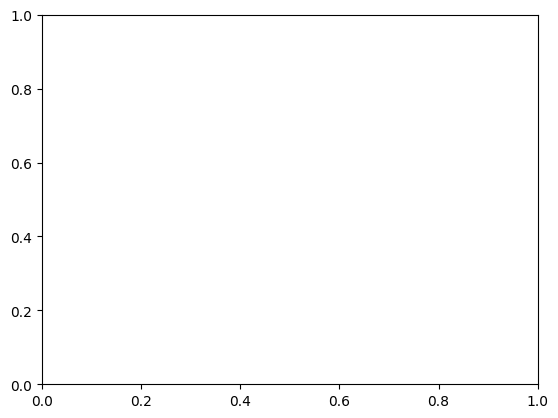

In [ ]:
# data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# ax = plt.gca()
# ax.set_xlim(left=0, right=19000)



# # 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN']



# plt.show()
times = df22[time_col_names].index.to_numpy()
display(times)
plt.plot(times, y_train22, label="Actual", marker="o")
plt.plot(times, predY, label="Predicted", linestyle="--", marker="x")



ax = plt.gca()
ax.set_xlim(left=12000, right=18000)
# 添加标题和标签
plt.title("Actual vs. Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")



# 添加图例
plt.legend()



# 显示图形
plt.show()

In [ ]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [ ]:
display(df22.columns)

In [ ]:
data22, scaler22 = normalize(df22, numeric_col_names)
X22 = data22[feature_col_names]
y_test22 =normalizeY( df22[label_col_names])
x_train22  = np.asarray(X22) .reshape(-1, feature_col_num) 
predY22 = model.predict(x_train22, batch_size=batch_size)


data23, scaler23 = normalize(df23, numeric_col_names) 
X23 = data23[feature_col_names]
y_test23 =normalizeY( df23[label_col_names])
x_train23  = np.asarray(X23) .reshape(-1, feature_col_num) 
predY23 = model.predict(x_train23, batch_size=batch_size)
 





display(predY22,predY23)

In [ ]:
fig_acc = plt.figure(figsize=(9, 9))
plt.plot(predY23[0:27000])
plt.plot(y_test23[0:27000])
plt.title("real vs pred")
plt.ylabel("value")
plt.xlabel("epoch")
plt.xlim((19000, 23000))
plt.legend(["pred", "real"], loc="upper left")
plt.show()